### Step 1: Problem statement

In this challenge, the ask it to complete the analysis of what sorts of people were likely to survive. In particular, the ask is to apply the tools of machine learning to predict which passengers survived the tragedy.

### Step 2: Collecting data

In this step we will import required libraries and data from csv files.

In [147]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

# Importing Pandas and NumPy
import pandas as pd, numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

In [148]:
# Importing all datasets
TitanicDataTr = pd.read_csv("train.csv")
TitanicDataTs = pd.read_csv("test.csv")

### Step 3: Exploratory data analysis

In this challenge, the ask it to complete the analysis of what sorts of people were likely to survive. In particular, the ask is to apply the tools of machine learning to predict which passengers survived the tragedy.

In [149]:
TitanicDataTr.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


| Variable | Definition | Key |
| --- | --- | --- |
| pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| survival | Survival | 0 = No, 1 = Yes |
| sex | Sex | Male/Female |
| Age | Age in years |  |
| sibsp | # of siblings / spouses aboard the Titanic |  |
| parch | # of parents / children aboard the Titanic |  |
| ticket | Ticket number |  |
| fare | Passenger fare |  |
| cabin | Cabin number |  |
| embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |	

### Working on outliers

In this step we will perform action on features to make them more meaningful.

In [150]:
TitanicDataTr.groupby(TitanicDataTr['Survived']).count()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Survived,,,,,,,,,,,
0,549,549,549,549,424,549,549,549,549,68,549
1,342,342,342,342,290,342,342,342,342,136,340


In [151]:
ColumnUnique = pd.DataFrame(columns=['Count'])
for i in TitanicDataTr.columns:
    ColumnUnique.loc[i]=[TitanicDataTr[i].value_counts().count()]
ColumnUnique.sort_values(by = "Count", ascending = False,inplace=True)

ColumnType=pd.DataFrame(TitanicDataTr.dtypes,columns=['Dtype'])
pd.merge(ColumnUnique,ColumnType,left_index=True,right_index=True)

,Count,Dtype
PassengerId,891,int64
Name,891,object
Ticket,681,object
Fare,248,float64
Cabin,147,object
Age,88,float64
SibSp,7,int64
Parch,7,int64
Pclass,3,int64
Embarked,3,object


In [152]:
# Outlier detection 
from collections import Counter

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method."""
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(TitanicDataTr,2,["Age","SibSp","Parch","Fare"])
print("percent of data with outliers values:", round((TitanicDataTr.loc[Outliers_to_drop].shape[0]/TitanicDataTr.shape[0])*100,2),"%",sep="")

percent of data with outliers values:1.12%


In [153]:
TitanicDataTr.drop(Outliers_to_drop,axis=0, inplace=True)

In [154]:
TitanicData=pd.concat([TitanicDataTr, TitanicDataTs], ignore_index=True)

## Dealing with missing values ##

In [155]:
TitanicData.isna().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

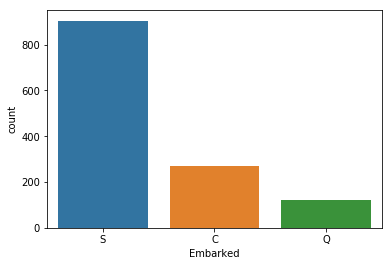

In [156]:
sns.countplot(x="Embarked",data=TitanicData)

In [157]:
TitanicData['Embarked'].fillna(TitanicData['Embarked'].value_counts().index[0],inplace=True)

(-15, 522.3292)

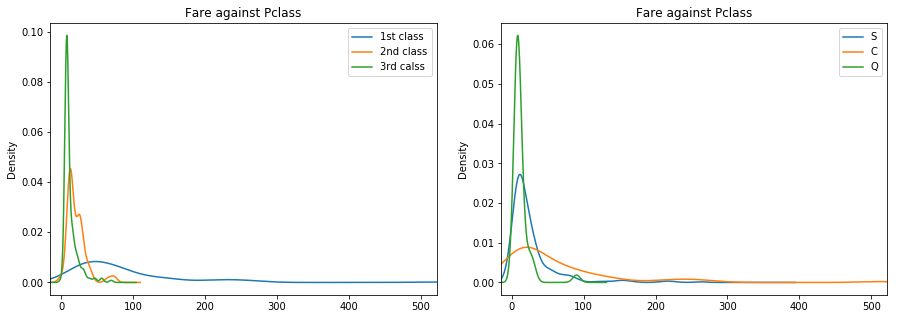

In [158]:
fig=plt.figure(figsize=(15,5))
plt.subplot2grid((1,4),(0,0),colspan=2)
fig.subplots_adjust(hspace=.5,wspace = 0.4)
for i in [1,2,3]:
    TitanicData.Fare[(TitanicData.Pclass==i) & (TitanicData.Fare.notnull())].plot(kind='kde')
plt.title("Fare against Pclass")
plt.legend(("1st class","2nd class","3rd calss"))
plt.xlim(-15,TitanicData.Fare[(TitanicData.Fare.notnull())].max()+10)

plt.subplot2grid((1,4),(0,2),colspan=2)
for i in ["S","C","Q"]:
    TitanicData.Fare[(TitanicData.Embarked==i) & (TitanicData.Fare.notnull())].plot(kind='kde')
plt.title("Fare against Pclass")
plt.legend(("S","C","Q"))
plt.xlim(-15,TitanicData.Fare[(TitanicData.Fare.notnull())].max()+10)

In [159]:
TitanicData['Fare'].fillna(TitanicData.groupby(["Pclass",'Embarked'])['Fare'].transform("median"),inplace=True)

In [160]:
TitanicData['Cabin']=TitanicData['Cabin'].str[0]

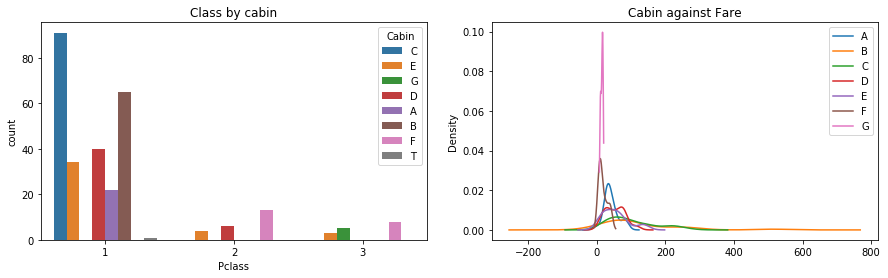

In [161]:
fig=plt.figure (figsize=(15,10))
fig.subplots_adjust(hspace=.5,wspace = 0.4)

plt.subplot2grid((2,4),(0,0),colspan=2)
sns.countplot (x='Pclass', hue='Cabin',data=TitanicData)
plt.title("Class by cabin")

plt.subplot2grid((2,4),(0,2),colspan=2)
for i in ['A','B','C','D','E','F','G']:
    TitanicData.Fare[TitanicData.Cabin==i].plot(kind='kde')
plt.title("Cabin against Fare")
plt.legend(('A','B','C','D','E','F','G'))

In [162]:
TitanicData['Cabin']=TitanicData.groupby(['Pclass','Fare'])['Cabin'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Z"))

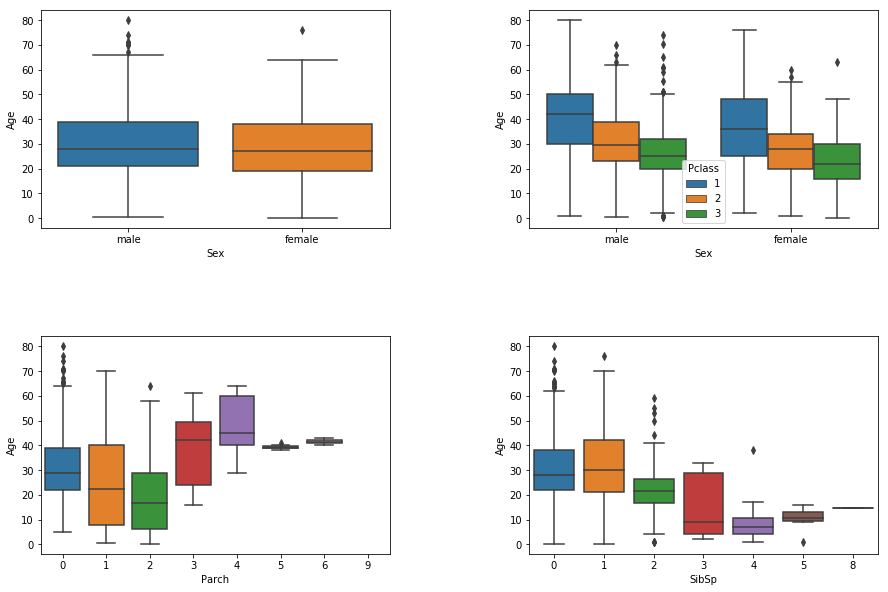

In [163]:
fig,ax=plt.subplots(2,2,figsize=(15,10))
ax=ax.flat
fig.subplots_adjust(hspace=.5,wspace = 0.4)
g = sns.catplot(y="Age",x="Sex",data=TitanicData,kind="box",ax=ax[0])
g = sns.catplot(y="Age",x="Sex",hue="Pclass", data=TitanicData,kind="box",ax=ax[1])
g.set_ylabels("survival probability")
g = sns.catplot(y="Age",x="Parch", data=TitanicData,kind="box",ax=ax[2])
g = sns.catplot(y="Age",x="SibSp", data=TitanicData,kind="box",ax=ax[3])
plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)

In [164]:
TitanicData["Title"]=(TitanicData["Name"].str.split(",", n = 1, expand = True))[1].str.split(".", n = 1, expand = True)[0]
TitanicData["Title"]=TitanicData["Title"].str.strip()

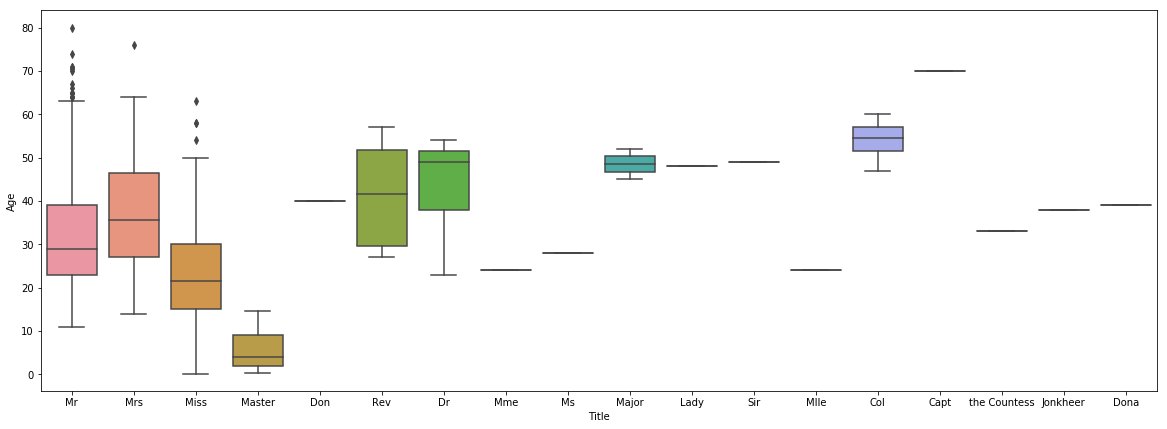

In [165]:
fig,ax=plt.subplots(figsize=(20,7))
fig.subplots_adjust(hspace=.5,wspace = 0.4)
g = sns.catplot(y="Age",x="Title",data=TitanicData,kind="box",ax=ax)
plt.tight_layout()
plt.close(2)

In [166]:
TitanicData["Title"]=TitanicData["Title"].apply(lambda x: 'Master' if x in ['Master'] else ('Miss' if x in ['Miss','Ms','Mile','Mme']
                                                                                    else ('Mrs' if x in ['Mrs','Lady','Dona','the Countess'] 
                                                                                    else ('Mr' if x in ['Mr','Sir','Don','Jonkheer'] 
                                                                                    else 'Others'))))

In [167]:
import math
AgeMedian=TitanicData['Age'].median()
TitanicData['Age']=TitanicData.groupby(['Pclass','SibSp','Parch','Title'])['Age'].transform(
    lambda x: x.fillna(x.median() if not math.isnan(x.median()) else AgeMedian))

In [168]:
TitanicDataTr=TitanicData[~TitanicData.Survived.isnull()]
TitanicDataTs=TitanicData[TitanicData.Survived.isnull()]

## Checking column behavior wrt survival data

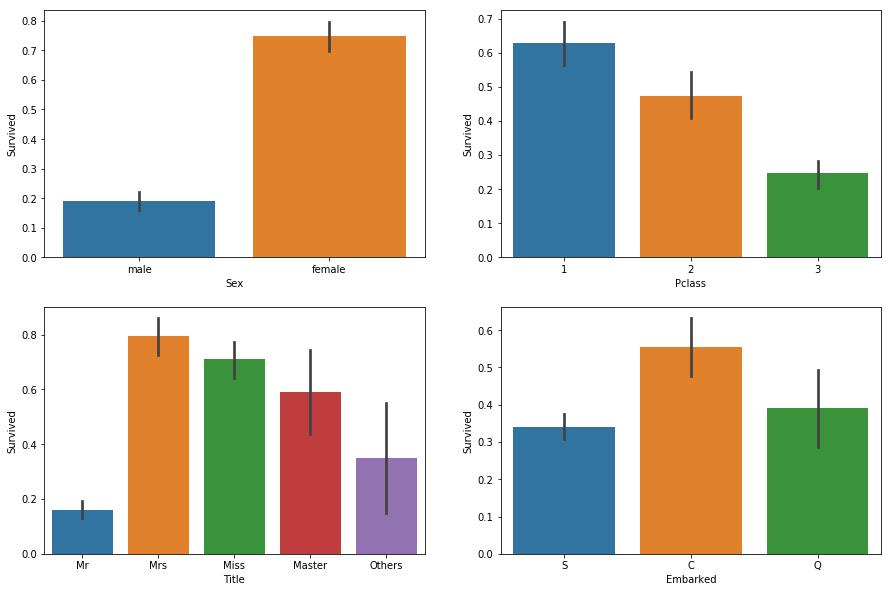

In [169]:
fig,ax=plt.subplots(2,2,figsize=(15,10))
ax=ax.flat
sns.catplot(y="Survived",x="Sex",data=TitanicDataTr,kind="bar",ax=ax[0])
sns.catplot(y="Survived",x="Pclass",data=TitanicDataTr,kind="bar",ax=ax[1])
sns.catplot(y="Survived",x="Title",data=TitanicDataTr,kind="bar",ax=ax[2])
sns.catplot(y="Survived",x="Embarked",data=TitanicDataTr,kind="bar",ax=ax[3])
plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)

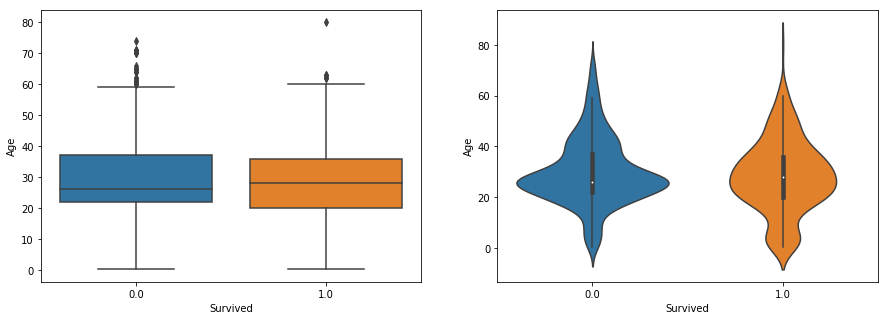

In [170]:
f,ax=plt.subplots(1,2,figsize=(15,5))
fig.subplots_adjust(hspace=.5,wspace = 0.4)
g = sns.catplot(x="Survived", y = "Age",data = TitanicData, kind="box",ax=ax[0])
g = sns.catplot(x="Survived", y = "Age",data = TitanicData, kind="violin",ax=ax[1])
plt.close(2)
plt.close(3)

(-15, 522.3292)

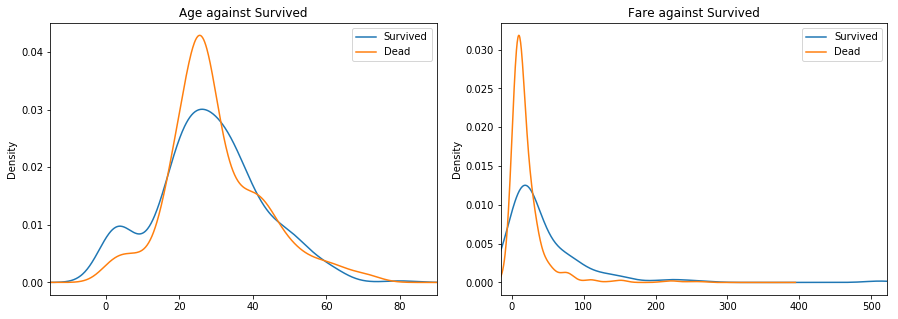

In [171]:
fig = plt.figure(figsize=(15,5 ))
plt.subplot2grid((1,4),(0,0),colspan=2)
fig.subplots_adjust(hspace=.5,wspace = 0.4)

for i in [1,0]:
    TitanicData.Age[(TitanicData.Survived==i) & (TitanicData.Survived.notnull())].plot(kind='kde')
plt.title("Age against Survived")
plt.legend(("Survived","Dead"))
plt.xlim(-15,TitanicData.Age[(TitanicData.Survived.notnull())].max()+10)

plt.subplot2grid((1,4),(0,2),colspan=2)
for i in [1,0]:
    TitanicData.Fare[(TitanicData.Survived==i) & (TitanicData.Survived.notnull())].plot(kind='kde')
plt.title("Fare against Survived")
plt.legend(("Survived","Dead"))
plt.xlim(-15,TitanicData.Fare[(TitanicData.Survived.notnull())].max()+10)

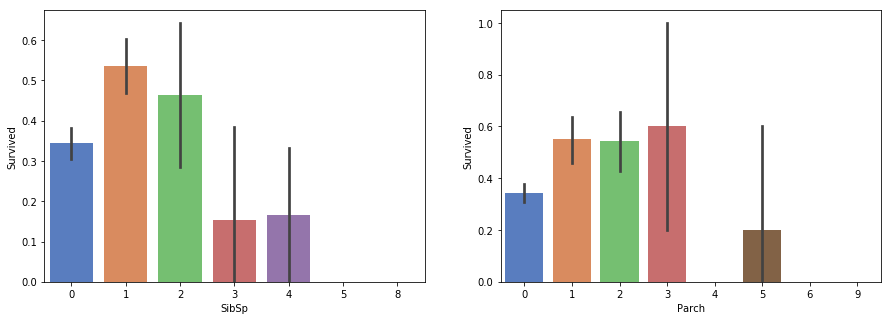

In [172]:
f,ax=plt.subplots(1,2,figsize=(15,5))
fig.subplots_adjust(hspace=.5,wspace = 0.4)

g=sns.catplot(x="SibSp",y="Survived",data=TitanicData,kind="bar", height = 6 , palette = "muted",ax=ax[0])
g.despine(left=True)
g = g.set_ylabels("survival probability")

g  = sns.catplot(x="Parch",y="Survived",data=TitanicData,kind="bar", height = 6 ,palette = "muted",ax=ax[1])
g.despine(left=True)
g = g.set_ylabels("survival probability")
plt.close(2)
plt.close(3)
# fig.show()

In [173]:
TitanicData["FamilySize"]=(TitanicData["SibSp"]+TitanicData["Parch"]+1)

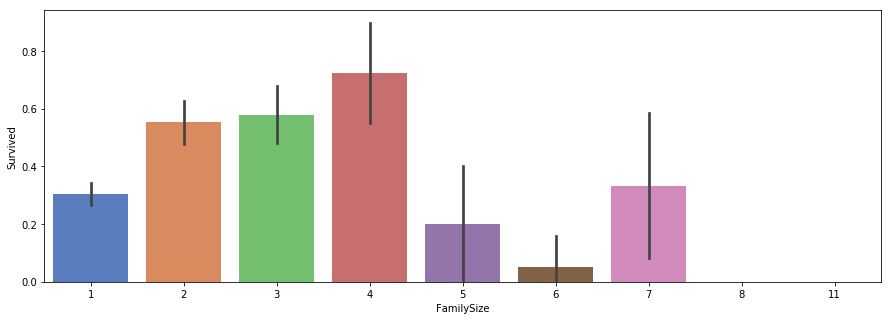

In [174]:
f,ax=plt.subplots(figsize=(15,5))
fig.subplots_adjust(hspace=.5,wspace = 0.4)

g=sns.catplot(x="FamilySize",y="Survived",data=TitanicData,kind="bar", height = 6 , palette = "muted",ax=ax)
g.despine(left=True)
g = g.set_ylabels("survival probability")
plt.close(2)

In [175]:
# Create new feature of family size
TitanicData['Single'] = TitanicData['FamilySize'].map(lambda s: 1 if s == 1 else 0)
TitanicData['Small_F'] = TitanicData['FamilySize'].map(lambda s: 1 if  2 <= s <= 3  else 0)
TitanicData['Med_F'] = TitanicData['FamilySize'].map(lambda s: 1 if 4 <= s <= 4 else 0)
TitanicData['Large_F'] = TitanicData['FamilySize'].map(lambda s: 1 if s >= 5 else 0)

In [176]:
gender = {'male': 0,'female': 1} 
TitanicData["Sex"]=TitanicData["Sex"].map(gender)

In [177]:
TitanicData["SurName"]=(TitanicData["Name"].str.split(",", n = 1, expand = True))[0]

In [178]:
TitanicData.set_index("PassengerId",inplace=True)

In [179]:
TitanicData=TitanicData[[c for c in TitanicData if c not in ['SurName', 'Ticket']] + ['SurName', 'Ticket']]
TitanicData.sort_values(['SurName', 'Ticket'],ascending=[True,True],inplace=True)

In [180]:
TitanicData['CumSum']= TitanicData.groupby(['SurName','Ticket']).cumcount()

In [181]:
TitanicData["Father"]=0
TitanicData["Mother"]=0
TitanicData["Child"]=0
TitanicData["Sibling"]=0
TitanicData["Spouse"]=0

In [182]:
def LogicalDivision(df):
    for index, row in df.iterrows():
        dfSmall = df[(df["SurName"]==row["SurName"]) & (df["Ticket"]==row["Ticket"])]
        if dfSmall.shape[0] > 1:
            if (dfSmall.Title.isin(['Mrs']).sum()>0):
                MAge = dfSmall[dfSmall.Title=='Mrs'].Age.min()
                for index1, row1 in dfSmall.iterrows():
                    if row1["Title"]=='Mrs' and row1["Age"] == MAge:
                        df.loc[index1,"Mother"]=1
                        df.loc[index1,"Spouse"]=1
                    elif row1["Title"] in ['Miss','Mr','Master'] and (row1["Age"] < MAge-10):
                        df.loc[index1,"Child"]=1
                        if (dfSmall.shape[0] >3):
                            df.loc[index1,"Sibling"]=1
                    elif row1["Title"] in ['Mr','Other'] and row1['Sex']==0 and (row1["Age"] > MAge-10):
                        df.loc[index1,"Father"]=1
                        df.loc[index1,"Spouse"]=1
                    else:
                        df.loc[index1,"Spouse"]=1
            else:
                if row1["FamilySize"] > 1:
                    df.loc[index,"Sibling"]=1
                    

LogicalDivision(TitanicData)

In [183]:
DropList=['Name','SurName','FamilySize','SurName','Ticket','CumSum']
DummyList=['Cabin','Embarked','Pclass','Title']

In [184]:
TitanicData.drop(DropList,axis=1,inplace=True)

In [185]:
# lets create dummies.
# Here we will first convert the data from categorical to numerical.
# We are not converting Company names now, as this will lead to more number of columns and logically also it doesn't
# add up to have brand name for price decision.
def ConvertCatInt(df_in, col_name):
    Dummy_Value=pd.get_dummies(df_in[col_name],col_name,drop_first=True)
    df_in=pd.concat([df_in,Dummy_Value],axis=1)
    df_in = df_in.iloc[:, :-1]
    df_in.drop(col_name,axis=1,inplace=True)
    return df_in

for columns in DummyList:
    TitanicData=ConvertCatInt(TitanicData,columns)

In [188]:
TitanicDataTest=TitanicData[TitanicData.Survived.isnull()]
TitanicDataTrain=TitanicData[~TitanicData.Survived.isnull()]

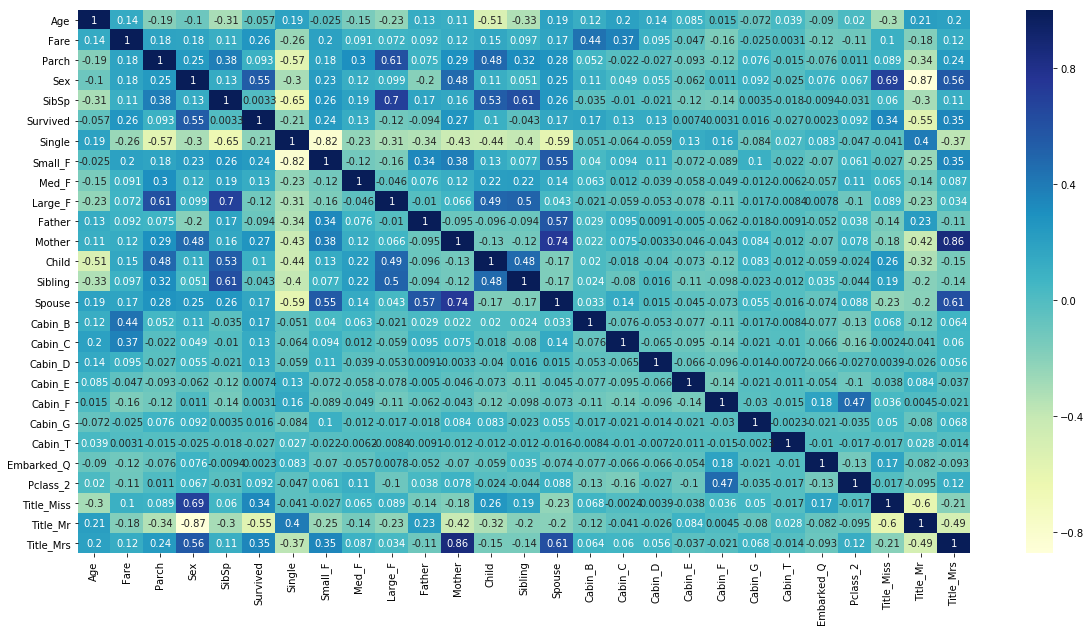

In [189]:
# we will plot a heatmap to look at the corelation in numerical form.
plt.figure(figsize=(20,10))
sns.heatmap(TitanicDataTrain.corr(),annot=True, cmap='YlGnBu')
plt.show()

In [190]:
y_train=TitanicDataTrain['Survived']
X_train=TitanicDataTrain[list(TitanicDataTrain.columns[~(TitanicDataTrain.columns == 'Survived')])]

In [191]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
ColumnListScale= ['Age','Fare']
X_train[ColumnListScale] = scaler.fit_transform(X_train[ColumnListScale])

In [192]:
import statsmodels.api as sm

In [193]:
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  881
Model:                            GLM   Df Residuals:                      855
Model Family:                Binomial   Df Model:                           25
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sat, 18 May 2019   Deviance:                          nan
Time:                        17:25:16   Pearson chi2:                     908.
No. Iterations:                   100   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.289e+05      0.723  -4.55e+05      0.000   -3.29e+05   -3.29e+05
Age           -0.4122      0.127     -3.237      0.001      -0.662      -0.163
Fare           0.3398      0.164      2.077      0.038       0.019       0.660
Parch          0.2807      0.280      1.001      0.317      -0.269       0.830
Sex           35.6392   2.54e+07   1.41e-06      1.000   -4.97e+07    4.97e+07
SibSp          0.2989      0.317      0.943      0.345      -0.322       0.920
Single      3.289e+05      0.617   5.33e+05      0.000    3.29e+05    3.29e+05
Small_F     3.289e+05      0.250   1.31e+06      0.000    3.29e+05    3.29e+05
Med_F       3.289e+05      0.594   5.54e+05      0.000    3.29e+05    3.29e+05
Large_F     3.289e+05      1.008   3.26e+05      0.000    3.29e+05    3.29e+05
Father         0.4674      1.096      0.426      0.670      -1.681       2.615
Mother        -0.0573      1.235     -0.046      0.963      -2.478       2.364
Child         -0.3412      0.515     -0.663      0.508      -1.351       0.668
Sibling       -0.5778      0.487     -1.185      0.236      -1.533       0.378
Spouse        -0.5973      1.122     -0.532      0.594      -2.796       1.602
Cabin_B        1.7757      0.505      3.518      0.000       0.786       2.765
Cabin_C        1.4985      0.421      3.558      0.000       0.673       2.324
Cabin_D        1.8429      0.470      3.922      0.000       0.922       2.764
Cabin_E        1.0423      0.335      3.111      0.002       0.386       1.699
Cabin_F        0.1428      0.294      0.486      0.627      -0.434       0.719
Cabin_G       -1.5257      1.055     -1.446      0.148      -3.594       0.543
Cabin_T    -4.504e+15   6.71e+07  -6.71e+07      0.000    -4.5e+15    -4.5e+15
Embarked_Q     0.0365      0.343      0.106      0.915      -0.636       0.709
Pclass_2       0.4979      0.274      1.819      0.069      -0.039       1.035
Title_Miss   -35.0246   2.54e+07  -1.38e-06      1.000   -4.97e+07    4.97e+07
Title_Mr      -2.0861      0.414     -5.038      0.000      -2.898      -1.275
Title_Mrs    -34.0367   2.54e+07  -1.34e-06      1.000   -4.97e+07    4.97e+07
==============================================================================
"""

In [194]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,Sex,73.97
23,Title_Miss,49.64
25,Title_Mrs,40.87
13,Spouse,31.13
10,Mother,23.18
8,Large_F,18.73
6,Small_F,18.35
5,Single,17.15
9,Father,13.12
4,SibSp,8.30


In [250]:
y_train=TitanicDataTrain['Survived']
# X_train=TitanicDataTrain[list(TitanicDataTrain.columns[~(TitanicDataTrain.columns == 'Survived')])]
ModelList=list(TitanicDataTrain.columns[~TitanicDataTrain.columns.isin(['SibSp','Fare','Parch','Survived','Sex',
                                                                        'Single','Small_F',"Med_F",'Father','Mother',
                                                                       'Child','Spouse','Sibling','Cabin_F'
                                                                        ,'Cabin_T','Cabin_Q','Embarked_Q','Cabin_G'])])
X_train=TitanicDataTrain[ModelList]
X_train_c=sm.add_constant(X_train)
logm1 = sm.GLM(y_train,X_train_c, family = sm.families.Binomial())
res=logm1.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  881
Model:                            GLM   Df Residuals:                      870
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -378.59
Date:                Sat, 18 May 2019   Deviance:                       757.18
Time:                        17:59:18   Pearson chi2:                     911.
No. Iterations:                     5   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6104      0.377      1.617      0.106      -0.129       1.350
Age           -0.0264      0.008     -3.227      0.001      -0.042      -0.010
Large_F       -2.5238      0.439     -5.744      0.000      -3.385      -1.663
Cabin_B        2.1274      0.422      5.045      0.000       1.301       2.954
Cabin_C        1.8254      0.350      5.222      0.000       1.140       2.511
Cabin_D        2.2054      0.446      4.941      0.000       1.331       3.080
Cabin_E        1.0633      0.323      3.288      0.001       0.429       1.697
Pclass_2       0.5481      0.236      2.318      0.020       0.085       1.012
Title_Miss     0.6388      0.369      1.731      0.084      -0.085       1.362
Title_Mr      -2.0972      0.359     -5.846      0.000      -2.800      -1.394
Title_Mrs      1.3582      0.424      3.204      0.001       0.527       2.189
==============================================================================
"""

In [251]:
y_train_pred = res.predict(X_train_c)
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.06933334, 0.73952688, 0.12901319, 0.15037802, 0.85528655,
       0.09281173, 0.24772444, 0.71327532, 0.81650944, 0.10210567])

In [252]:
y_train_pred_final = pd.DataFrame({'Survived':y_train.values, 'Survived_Prob':y_train_pred})
y_train_pred_final['PassengerId'] = y_train.index
y_train_pred_final.head()

,Survived,Survived_Prob,PassengerId
0,0.0,0.069333,846
1,1.0,0.739527,280
2,0.0,0.129013,747
3,0.0,0.150378,309
4,1.0,0.855287,875


In [253]:
y_train_pred_final['predicted'] = y_train_pred_final.Survived_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,Survived,Survived_Prob,PassengerId,predicted
0,0.0,0.069333,846,0
1,1.0,0.739527,280,1
2,0.0,0.129013,747,0
3,0.0,0.150378,309,0
4,1.0,0.855287,875,1


In [254]:
from sklearn import metrics

# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Survived, y_train_pred_final.predicted )
print(confusion)

[[469  72]
 [ 86 254]]


In [255]:
print("Accuracy of model:", round(metrics.accuracy_score(y_train_pred_final.Survived, y_train_pred_final.predicted),2))

Accuracy of model: 0.82


In [256]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Survived_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Survived,Survived_Prob,PassengerId,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.0,0.069333,846,0,1,0,0,0,0,0,0,0,0,0
1,1.0,0.739527,280,1,1,1,1,1,1,1,1,1,0,0
2,0.0,0.129013,747,0,1,1,0,0,0,0,0,0,0,0
3,0.0,0.150378,309,0,1,1,0,0,0,0,0,0,0,0
4,1.0,0.855287,875,1,1,1,1,1,1,1,1,1,1,0


In [257]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy'])
from sklearn.metrics import confusion_matrix
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Survived, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    cutoff_df.loc[i] =[ i ,accuracy]
print(cutoff_df)

     prob  accuracy
0.0   0.0  0.385925
0.1   0.1  0.494892
0.2   0.2  0.769580
0.3   0.3  0.809308
0.4   0.4  0.819523
0.5   0.5  0.820658
0.6   0.6  0.819523
0.7   0.7  0.801362
0.8   0.8  0.752554
0.9   0.9  0.685585


In [258]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Survived_Prob.map( lambda x: 1 if x > 0.5 else 0)
metrics.accuracy_score(y_train_pred_final.Survived, y_train_pred_final.final_predicted)

0.8206583427922814

In [259]:
X_test=TitanicDataTest.drop(["Survived"],axis=1)
X_test[ColumnListScale] = scaler.transform(X_test[ColumnListScale])

In [260]:
X_test=TitanicDataTest[ModelList]
X_test_sm = sm.add_constant(X_test)

In [261]:
y_test_pred = res.predict(X_test_sm)

y_test_df = pd.DataFrame(y_test_pred)

# Putting CustID to index
y_test_df['PassengerId'] = y_test_df.index
y_test_df.reset_index(drop=True, inplace=True)

y_test_df= y_test_df.rename(columns={ 0 : 'Survived_Prob'})

y_test_df['Survived'] = y_test_df.Survived_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_test_df.drop(['Survived_Prob'],axis=1,inplace=True)

In [262]:
y_test_df.to_csv("New_Result.csv",index=False)